In [190]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re



In [153]:
df = pd.read_csv("../enron_1.csv")

In [154]:
# 1. Check for NaNs in the processed text
num_nans = df['final_text'].isnull().sum()
print("NaNs in final_text:", num_nans)

# 2. Check for empty strings (after stripping whitespace)
num_empty = (df['final_text'].str.strip() == '').sum()
print("Empty strings in final_text:", num_empty)

# 3. Check for placeholder presence
placeholders = ['<url>', '<email>', '<num>']
placeholder_counts = {ph: df['final_text'].str.contains(ph, case=False).sum() for ph in placeholders}
print("Placeholder counts:", placeholder_counts)


NaNs in final_text: 1
Empty strings in final_text: 0
Placeholder counts: {'<url>': 49, '<email>': 0, '<num>': 22882}


### Split Data into Train/Test

In [155]:
print(df.isnull().sum())


is_spam       0
final_text    1
dtype: int64


In [156]:
df = df.dropna(subset=['final_text']) # Drop rows that are NaN

df = df[~df['final_text'].str.replace(r'\s+', '', regex=True).eq('')] # Drop rows that are empty or just whitespace

df = df.reset_index(drop=True)


In [157]:
print(df.isnull().sum())


is_spam       0
final_text    0
dtype: int64


In [158]:
# Keep only rows with actual text
df = df[df['final_text'].str.strip() != ""]  # remove empty strings
df = df.reset_index(drop=True)               # optional, reset row numbers


In [159]:
X = df['final_text']  # preprocessed email text
y = df['is_spam']     # labels: 0 = ham, 1 = spam


In [160]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% of data for testing
    random_state=42,     # ensures reproducibility
    stratify=y           # preserves the spam/ham ratio in train/test
)


In [161]:
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest label distribution:")
print(y_test.value_counts(normalize=True))


Train size: 22435, Test size: 5609

Train label distribution:
is_spam
0    0.508759
1    0.491241
Name: proportion, dtype: float64

Test label distribution:
is_spam
0    0.508825
1    0.491175
Name: proportion, dtype: float64


## Data Engineering/Extraction

### TF-IDF Vectorization

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].dropna()) #feature matrix, the numerical representation of all our documents


TF-IDF extracts each unique word (or n-gram), builds a vocabulary

In [163]:
print(tfidf.get_feature_names_out())


['aa' 'ab' 'ability' ... 'zone' 'zone www' 'zonedubai']


builds/returns a vocabulary of all unique words (or n-grams) it learned from your corpus.

above shows only the words that actually appear in the first email, along with their importance scores.

In [164]:
print(X_tfidf.shape)

(28044, 5000)


### Inspect / Analyze TF-IDF

In [165]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:50])        # preview first 20 words

5000
['aa' 'ab' 'ability' 'able' 'abroad' 'absence' 'absolutely' 'abuse' 'ac'
 'academic' 'accept' 'acceptable' 'acceptance' 'acceptance term'
 'accepted' 'access' 'accessory' 'accomplish' 'accordance' 'according'
 'accordingly' 'account' 'accountant' 'accounting' 'accounting investment'
 'accuracy' 'accuracy completeness' 'accurate' 'achieve' 'achievement'
 'acquire' 'acquired' 'acquiring' 'acquisition' 'acre' 'acrobat'
 'acrobat num' 'act' 'act num' 'action' 'action identified' 'action occur'
 'active' 'activity' 'actua' 'actual' 'actual result' 'actually' 'acy'
 'acy ne']


Above checks TF-IDF vocabulary

In [166]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores


               tfidf
accomplish  0.058466
activity    0.042010
advance     0.048357
agreement   0.037281
allow       0.042633
...              ...
utility     0.091012
volume      0.037022
waiting     0.046907
wondering   0.058271
working     0.034776

[140 rows x 1 columns]


In [167]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 98.62%


Out of all the entries in your TF-IDF matrix, 98.62% are zeros.
Only 1.38% of the cells have a non-zero TF-IDF value.

In [168]:
feature_names = tfidf.get_feature_names_out()

# Convert the first few emails to a readable table
tfidf_df = pd.DataFrame(
    X_tfidf[:20].toarray(),      # first 5 rows (emails)
    columns=feature_names       # columns = words
)

print(tfidf_df.head(20))


     aa   ab  ability      able  abroad  absence  absolutely  abuse   ac  \
0   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
1   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
2   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
3   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
4   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
5   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
6   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
7   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
8   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
9   0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
10  0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
11  0.0  0.0      0.0  0.000000     0.0      0.0         0.0    0.0  0.0   
12  0.0  0.0

### Visual rep of top words by TF-IDF score

C:\Users\lle34\AppData\Local\Temp\ipykernel_2000\786550444.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')


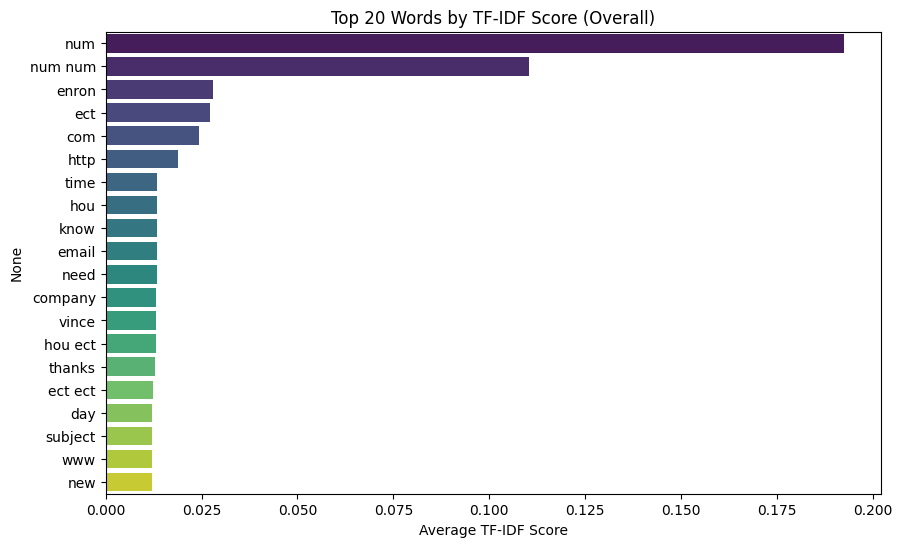

In [169]:
# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Average TF-IDF for each word
avg_tfidf = tfidf_df.mean(axis=0).sort_values(ascending=False)

# Top 20 words
top_words = avg_tfidf.head(20)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')
plt.xlabel('Average TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score (Overall)')
plt.show()


In [170]:
print("Top 20 words by average TF-IDF:")
for i, (word, score) in enumerate(top_words.items(), 1):
    print(f"{i}. {word} (avg TF-IDF: {score:.4f})")


Top 20 words by average TF-IDF:
1. num (avg TF-IDF: 0.1924)
2. num num (avg TF-IDF: 0.1103)
3. enron (avg TF-IDF: 0.0281)
4. ect (avg TF-IDF: 0.0271)
5. com (avg TF-IDF: 0.0242)
6. http (avg TF-IDF: 0.0190)
7. time (avg TF-IDF: 0.0134)
8. hou (avg TF-IDF: 0.0134)
9. know (avg TF-IDF: 0.0134)
10. email (avg TF-IDF: 0.0133)
11. need (avg TF-IDF: 0.0133)
12. company (avg TF-IDF: 0.0132)
13. vince (avg TF-IDF: 0.0131)
14. hou ect (avg TF-IDF: 0.0130)
15. thanks (avg TF-IDF: 0.0130)
16. ect ect (avg TF-IDF: 0.0123)
17. day (avg TF-IDF: 0.0122)
18. subject (avg TF-IDF: 0.0122)
19. www (avg TF-IDF: 0.0120)
20. new (avg TF-IDF: 0.0120)


In [183]:


# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top)


Top TF-IDF words in spam (avg):
num            0.163052
num num        0.069887
http           0.033922
com            0.031109
email          0.020009
www            0.019607
company        0.018531
click          0.018225
http www       0.016444
price          0.014929
money          0.014438
best           0.014415
site           0.014373
offer          0.014276
free           0.014197
save           0.014027
software       0.013902
online         0.013645
time           0.013394
want           0.013327
business       0.012281
info           0.012254
order          0.012178
day            0.012065
like           0.011933
information    0.011875
new            0.011820
account        0.011491
net            0.011394
product        0.011214
need           0.011144
mail           0.010975
website        0.010840
life           0.010509
visit          0.010437
stop           0.010393
make           0.010142
medication     0.009753
hello          0.009661
message        0.009499
dtype: f

## Additional features (to test)

- Common keywords
- placeholders count
- word count
- char count 
- Avg word length

### Exploring common phishing keywords

In [193]:
# candidate_words: list of words/phrases you picked (strings)
candidate_words = ['verify', 'account', 'click', 'login', 'password', 'bank', 'transfer', 'invoice', 'free', 'win']  # example

for w in candidate_words:
    col = f'has_kw_{w}'
    df[col] = df['final_text'].str.contains(r'\b' + re.escape(w) + r'\b').astype(int)

# Evaluate how many spam emails contain each keyword
kw_summary = {}
for w in candidate_words:
    col = f'has_kw_{w}'
    tp = ((df[col]==1) & (df['is_spam']==1)).sum()
    fp = ((df[col]==1) & (df['is_spam']==0)).sum()
    in_email = (df[col]==1).sum()
    kw_summary[w] = {'in_email': in_email, 'spam_hits': tp, 'nonspam_hits': fp, 'spam_likelihood': tp/(in_email+1e-9)}
pd.DataFrame.from_dict(kw_summary, orient='index').sort_values('spam_likelihood', ascending=False)


,in_email,spam_hits,nonspam_hits,spam_likelihood
click,2514,1999,515,0.795147
account,1777,1215,562,0.683737
bank,1079,716,363,0.663577
transfer,845,558,287,0.660355
free,2909,1884,1025,0.647645
win,255,155,100,0.607843
verify,346,186,160,0.537572
login,96,44,52,0.458333
password,358,104,254,0.290503
invoice,264,17,247,0.064394


In [171]:
df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['final_text'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['final_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
df['num_placeholder_count'] = df['final_text'].str.count(r'<num>')
df['email_placeholder_count'] = df['final_text'].str.count(r'<email>')
df['url_placeholder_count'] = df['final_text'].str.count(r'<url>')


In [172]:
df.sample(10)

,is_spam,final_text,word_count,char_count,avg_word_length,num_placeholder_count,email_placeholder_count,url_placeholder_count
9097,1,claim home depot gift card <num> value sure fi...,15,93,5.266667,1,0,0
16051,1,hello ash good computer think site functining ...,53,340,5.433962,1,0,0
12825,0,<num> deal added <num> missed last week report...,30,183,5.133333,9,0,0
7180,0,fyi <num> <num> meeting today mike forwarded m...,346,2477,6.161850,23,0,0
23084,0,michelle please ammend oneok buston processing...,16,125,6.875000,2,0,0
10774,0,planned call per dyrvik morning lou eber sugge...,148,1027,5.945946,12,0,0
7167,0,thanks probably familar format <num> <num> min...,56,360,5.446429,14,0,0
12855,0,faith please find attached budget tx gas orig ...,87,593,5.827586,9,0,0
26671,1,dimness antithesis gnat miscellaneous besettin...,48,408,7.520833,6,0,0
20168,0,preliminary result round <num> testing managem...,203,1371,5.758621,22,0,0


In [173]:
# Count how many emails contain <url>
num_with_url = df['final_text'].str.contains(r'<url>').sum()

# Count how many contain <email>
num_with_email = df['final_text'].str.contains(r'<email>').sum()

# Count how many contain <num>
num_with_num = df['final_text'].str.contains(r'<num>').sum()

print("Emails with <url>:", num_with_url)
print("Emails with <email>:", num_with_email)
print("Emails with <num>:", num_with_num)



Emails with <url>: 49
Emails with <email>: 0
Emails with <num>: 22882


### Unsual/rare word feature 
- signal for unusual or suspicious words

In [174]:
from collections import Counter

# join all words in the corpus into huge string
all_words = " ".join(df['final_text']).split()  # Use your cleaned text column

# Count the frequency of each word
word_counts = Counter(all_words)

# Define and store rare words (appearing < 5 times) 
rare_words = {w for w, c in word_counts.items() if c < 5}

# Function to count rare words per email
def count_rare_words(text):
    return sum(1 for w in str(text).split() if w in rare_words)

df['rare_word_count'] = df['final_text'].apply(count_rare_words)


In [175]:
df.sample(5)

,is_spam,final_text,word_count,char_count,avg_word_length,num_placeholder_count,email_placeholder_count,url_placeholder_count,rare_word_count
4770,0,sharon carol jeremy blachman called vince kami...,72,491,5.833333,20,0,0,0
18728,1,received virtual postcard aunt edna pick postc...,85,546,5.435294,9,0,0,0
26610,1,burroughs depositary quadrangular working <num...,127,898,6.078740,9,0,0,2
21397,1,want know save <num> paymastergeneral n piils ...,64,427,5.687500,3,0,0,15
7097,0,thanks vince congratulation promotion vince j ...,26,180,5.961538,5,0,0,1


In [176]:
numeric_features = ['word_count','char_count','avg_word_length',
                    'num_placeholder_count','rare_word_count']
df[numeric_features + ['is_spam']].corr()['is_spam']


word_count              -0.045481
char_count              -0.039393
avg_word_length          0.108990
num_placeholder_count   -0.081304
rare_word_count          0.134191
is_spam                  1.000000
Name: is_spam, dtype: float64

### Investigate rare word feature

In [177]:
df['has_rare_word'] = (df['rare_word_count'] > 0).astype(int)

# Step 2: Group by spam label and calculate counts and percentages
summary = df.groupby('is_spam')['has_rare_word'].agg(
    total_emails='count',
    emails_with_rare_words='sum'
)

# Step 3: Add percentage column
summary['percentage_with_rare_words'] = (
    summary['emails_with_rare_words'] / summary['total_emails'] * 100
)

# Step 4: Display the summary
print(summary)

         total_emails  emails_with_rare_words  percentage_with_rare_words
is_spam                                                                  
0               14268                    7139                   50.035043
1               13776                   10629                   77.155923


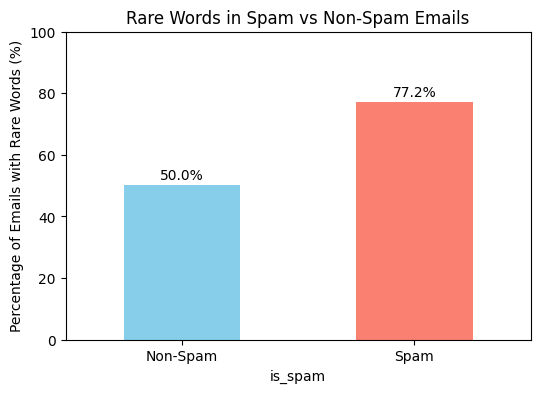

In [178]:
import matplotlib.pyplot as plt

# Use the summary you already created
percentages = summary['percentage_with_rare_words']

# Bar chart
plt.figure(figsize=(6,4))
percentages.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Non-Spam', 'Spam'], rotation=0)
plt.ylabel('Percentage of Emails with Rare Words (%)')
plt.title('Rare Words in Spam vs Non-Spam Emails')
plt.ylim(0,100)

# Add value labels on top of bars
for i, val in enumerate(percentages):
    plt.text(i, val + 2, f'{val:.1f}%', ha='center')

plt.show()


### Exploring emails with specific rare word under a condition
- number of rare words

In [179]:
threshold = 4
df['many_rare_words'] = (df['rare_word_count'] >= threshold).astype(int)

# Result: a summary DataFrame showing counts for spam vs non-spam.
summary = df.groupby('is_spam')['many_rare_words'].agg(
    total_emails='count',
    emails_with_many_rare_words='sum'
)

# compute %
summary['percentage_with_many_rare_words'] = (
    summary['emails_with_many_rare_words'] / summary['total_emails'] * 100
)

summary.head()

,total_emails,emails_with_many_rare_words,percentage_with_many_rare_words
is_spam,,,
0,14268,2114,14.816372
1,13776,5780,41.957027


- Non-spam emails: only ~15% contain many rare words.
- Spam emails: ~42% contain many rare words — almost 3x higher than non-spam

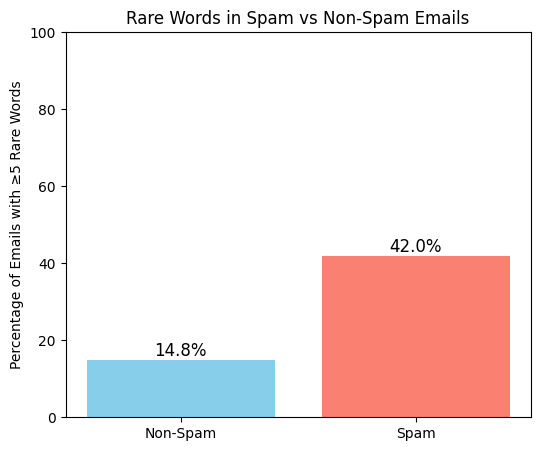

In [180]:
import matplotlib.pyplot as plt

# Use your summary dataframe
percentages = summary['percentage_with_many_rare_words']

plt.figure(figsize=(6,5))
bars = plt.bar(['Non-Spam', 'Spam'], percentages, color=['skyblue','salmon'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=12)

plt.ylim(0, 100)
plt.ylabel('Percentage of Emails with ≥5 Rare Words')
plt.title('Rare Words in Spam vs Non-Spam Emails')
plt.show()


### Explore average word len in norm vs. spam

In [181]:
# For simplicity, split at the median
median_length = df['avg_word_length'].median()
df['avg_word_length_high'] = (df['avg_word_length'] >= median_length).astype(int)



In [182]:
summary_length = df.groupby('avg_word_length_high')['is_spam'].agg(
    total_emails='count',
    spam_emails='sum'
)

summary_length['percentage_spam'] = summary_length['spam_emails'] / summary_length['total_emails'] * 100
print(summary_length)


                      total_emails  spam_emails  percentage_spam
avg_word_length_high                                            
0                            14010         6251        44.618130
1                            14034         7525        53.619781


- There is a higher percentage of spam emails containing longer words